In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
%matplotlib inline
pd.options.display.mpl_style = 'default'
pd.set_option('display.max_columns', 36)
%load_ext rpy2.ipython

In [2]:
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

py.sign_in("duygu", "z0is7y6mqf")

In [4]:
csv_data_dir = "yelp_csv"
clean_data_dir = "json_clean"

!ls $csv_data_dir

all_p1.csv  yelp_academic_dataset_business.csv	yelp_academic_dataset_user.csv


In [5]:
all_csv_filename = os.path.join(csv_data_dir, 'all_p1.csv')
all_DF = pd.read_csv(all_csv_filename)

In [6]:
type_columns_indices = np.nonzero(map(lambda col_name : col_name.startswith('type'), all_DF.columns))
all_DF.drop(all_DF.columns[type_columns_indices], axis=1, inplace=True)

# Stars, Stars, Stars

In [6]:
N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610']) 

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning:

findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=x-large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf



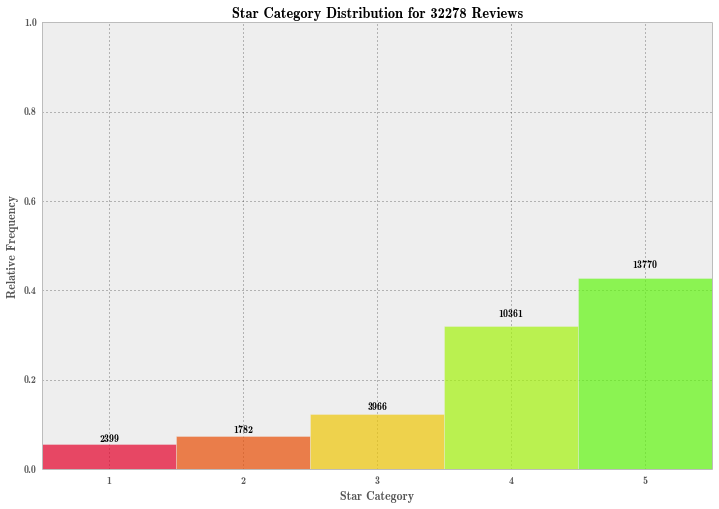

In [7]:
stars_labels = np.array([x_stars+1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize=(12,8))
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = all_DF.review_stars.value_counts(ascending=True)
star_category_relative_frequencies = np.array(star_category_absolute_frequencies)/float(sum(star_category_absolute_frequencies))

rects = plt.bar(bar_plot_indices, star_category_relative_frequencies, width=1, color=colors, alpha=.7)
for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x()+rect.get_width()/2., 1.05*rect.get_height(), '%d'%int(star_category_absolute_frequencies[idx+1]),
                ha='center', va='bottom')


plt.xticks(bar_plot_indices+.5, stars_labels)
plt.xlabel('Star Category')
plt.ylabel('Relative Frequency')
plt.ylim([0,1])
plt.title('Star Category Distribution for {0} Reviews'.format(len(all_DF)))

Not from statistical point of view but just one observation, I think people login to Yelp to tell what they like.

# NLP parts

In [7]:
yelp_output_dir = "yelp_output"
review_stars_bigrams_dir = os.path.join(yelp_output_dir, 'review_stars_bigrams')
review_stars_trigrams_dir = os.path.join(yelp_output_dir, 'review_stars_trigrams')

if not os.path.exists(review_stars_bigrams_dir):
    os.makedirs(review_stars_bigrams_dir)

if not os.path.exists(review_stars_trigrams_dir):
    os.makedirs(review_stars_trigrams_dir)

In [8]:
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter

In [9]:
nltk_stopwords = set(stopwords.words('english'))
def lowercase_remove_punctuation_and_tokenize(s):
    s = s.lower()
    s = s.translate(None, string.punctuation)
    # may consider removing arabic-hindu digits
    token_list = nltk.word_tokenize(s)
    exclude_stopwords = lambda token : token not in nltk_stopwords
    return filter(exclude_stopwords, token_list)

def concatenate_and_preprocess_and_tokenize_review_texts(sub_dataframe):
    s = sub_dataframe.review_text.sum()
    return lowercase_remove_punctuation_and_tokenize(s)

In [9]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features = all_DF[initial_features]
df_needed_to_find_ngram_counts_by_star_categories = df_with_initial_features
stars_vs_cat_texts = df_needed_to_find_ngram_counts_by_star_categories.groupby('review_stars').apply(concatenate_and_preprocess_and_tokenize_review_texts)

## Review Length and Stars

In [10]:
df_with_initial_features['review_length'] = df_with_initial_features.review_text.apply(lambda s : len(lowercase_remove_punctuation_and_tokenize(s)))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



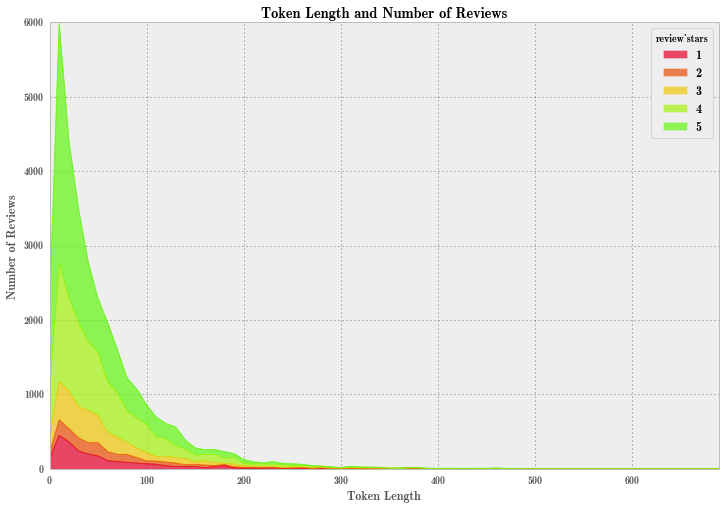

In [13]:
df_with_initial_features['review_length_category'] = df_with_initial_features.review_length.apply(lambda rl : rl/10)
df_with_initial_features_by_length_category_and_stars = df_with_initial_features.groupby(['review_length_category', 'review_stars'])
star_count_by_review_length_and_category = df_with_initial_features_by_length_category_and_stars.size()
star_count_by_review_length_in_units_of_10 = star_count_by_review_length_and_category.unstack(level=1)
whereNaN = np.isnan(star_count_by_review_length_in_units_of_10)
star_count_by_review_length_in_units_of_10[whereNaN] = 0
star_count_by_review_length_in_units_of_10.plot(kind='area', figsize=(12,8), color=colors, alpha=0.7)

plt.xlabel('Token Length')
review_length_range = (min(df_with_initial_features.review_length_category), max(df_with_initial_features.review_length_category));
xtick_labels = 10*np.arange(review_length_range[0], review_length_range[1], 10);
x = np.arange(review_length_range[0], review_length_range[1], 10);
plt.xticks(x, xtick_labels);

plt.ylabel('Number of Reviews')
plt.title('Token Length and Number of Reviews')

In [14]:
one_star_token_set = set(stars_vs_cat_texts[1])
two_star_token_set = set(stars_vs_cat_texts[2])
three_star_token_set = set(stars_vs_cat_texts[3])
four_star_token_set = set(stars_vs_cat_texts[4])
five_star_token_set = set(stars_vs_cat_texts[5])

Vocabulary = reduce(set.union, [set(stars_vs_cat_texts[x+1]) for x in range(N_star_categories)])

In [15]:
for xstars in range(0, 5):
    bigrams = ["%s %s" % bi for bi in nltk.bigrams(stars_vs_cat_texts[xstars+1])]
    bigrams_df = DataFrame.from_dict(Counter(bigrams).most_common(len(stars_vs_cat_texts[xstars+1])))
    bigram_csv_filepath = os.path.join(review_stars_bigrams_dir, '{0}_star.csv'.format(xstars+1))
    bigrams_df.to_csv(bigram_csv_filepath, index=False)
    
    trigrams = ["%s %s %s" % tri for tri in nltk.trigrams(stars_vs_cat_texts[xstars+1])]
    trigrams_df = DataFrame.from_dict(Counter(trigrams).most_common(len(stars_vs_cat_texts[xstars+1])))
    trigram_csv_filepath = os.path.join(review_stars_trigrams_dir, '{0}_star.csv'.format(xstars+1))
    trigrams_df.to_csv(trigram_csv_filepath, index=False)

In [11]:
%%R
library(tm)
library(wordcloud)
library(RColorBrewer)

/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning:

Loading required package: NLP


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning:

Loading required package: RColorBrewer




In [17]:
%%R -i yelp_output_dir,review_stars_trigrams_dir,review_stars_bigrams_dir

palettes <- c("Reds", "Oranges", "Blues", "Purples", "Greens")

for (xstars in 1:5) {
    xstars.bigrams.path <- paste(review_stars_bigrams_dir, '/', xstars, '_star.csv',sep='')
    xstars.trigrams.path <- paste(review_stars_trigrams_dir, '/', xstars, '_star.csv',sep='')
    xstars.bigrams.df <- read.csv(xstars.bigrams.path)
    xstars.trigrams.df <- read.csv(xstars.trigrams.path)
    xstars.wordcloud.df <- rbind(xstars.bigrams.df[1:100,], xstars.trigrams.df[1:100,])
    xstars.wordcloud.df <- xstars.wordcloud.df[with(xstars.wordcloud.df, order(-X1, X0)),]
    
    pal <- brewer.pal(9, palettes[xstars])
    pal <- pal[-(1:3)]
    png(paste(yelp_output_dir, '/', xstars, '_star_wordcloud.png',sep=''), width=960, height=960)
    wordcloud(xstars.wordcloud.df$X0, xstars.wordcloud.df$X1 , max.words=200, colors=pal)
    dev.off()
}


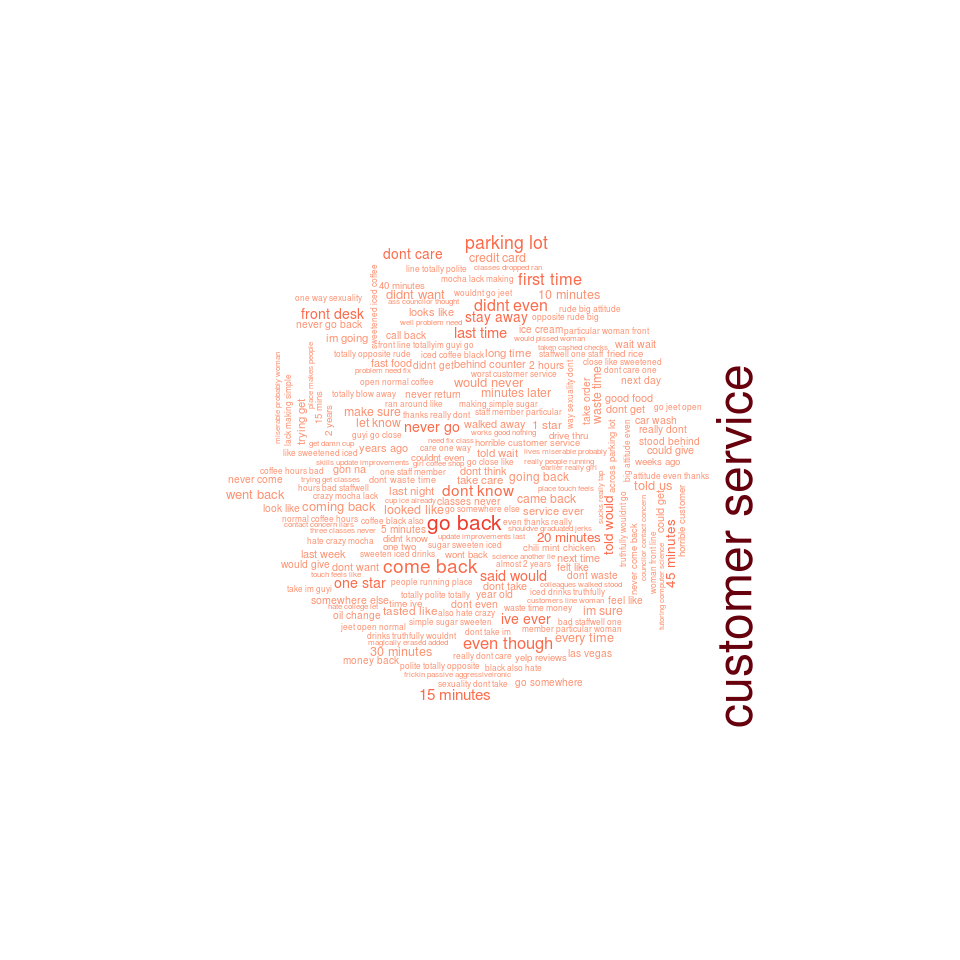

In [12]:
from IPython.core.display import Image
Image(filename=os.path.join(yelp_output_dir, '1_star_wordcloud.png'))

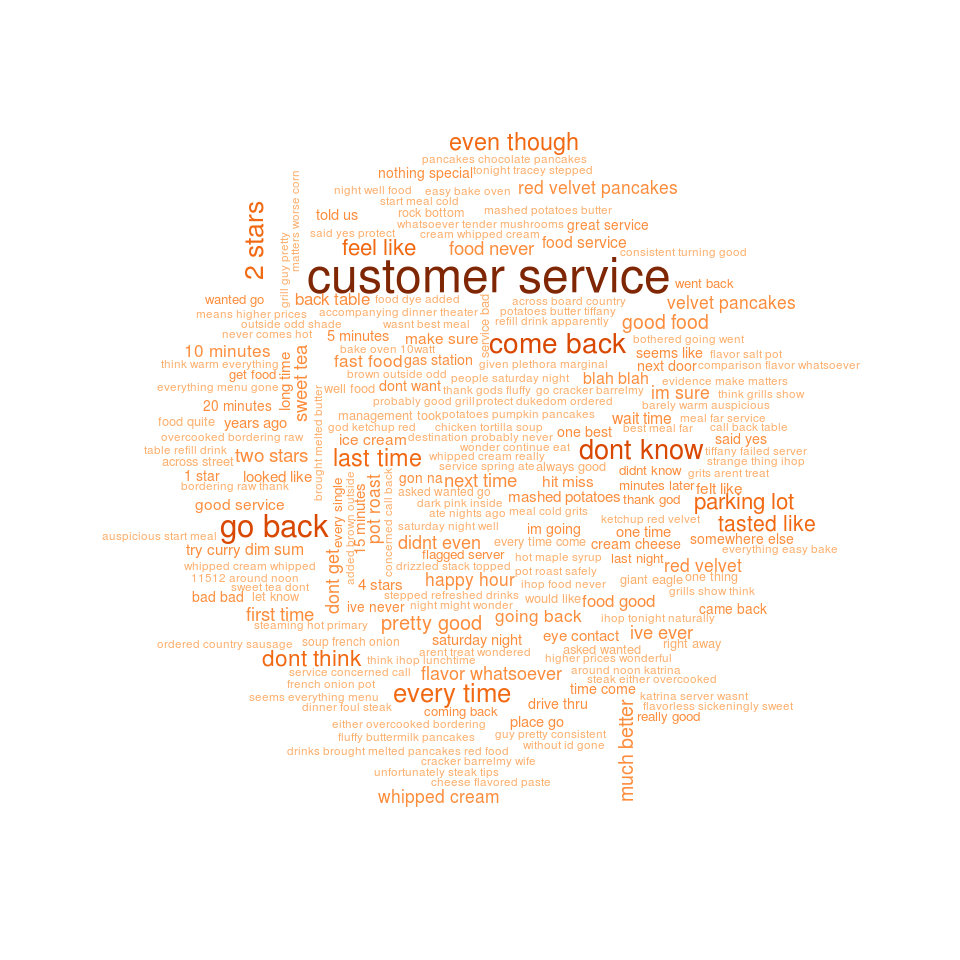

In [13]:
from IPython.core.display import Image
Image(filename=os.path.join(yelp_output_dir, '2_star_wordcloud.png'))

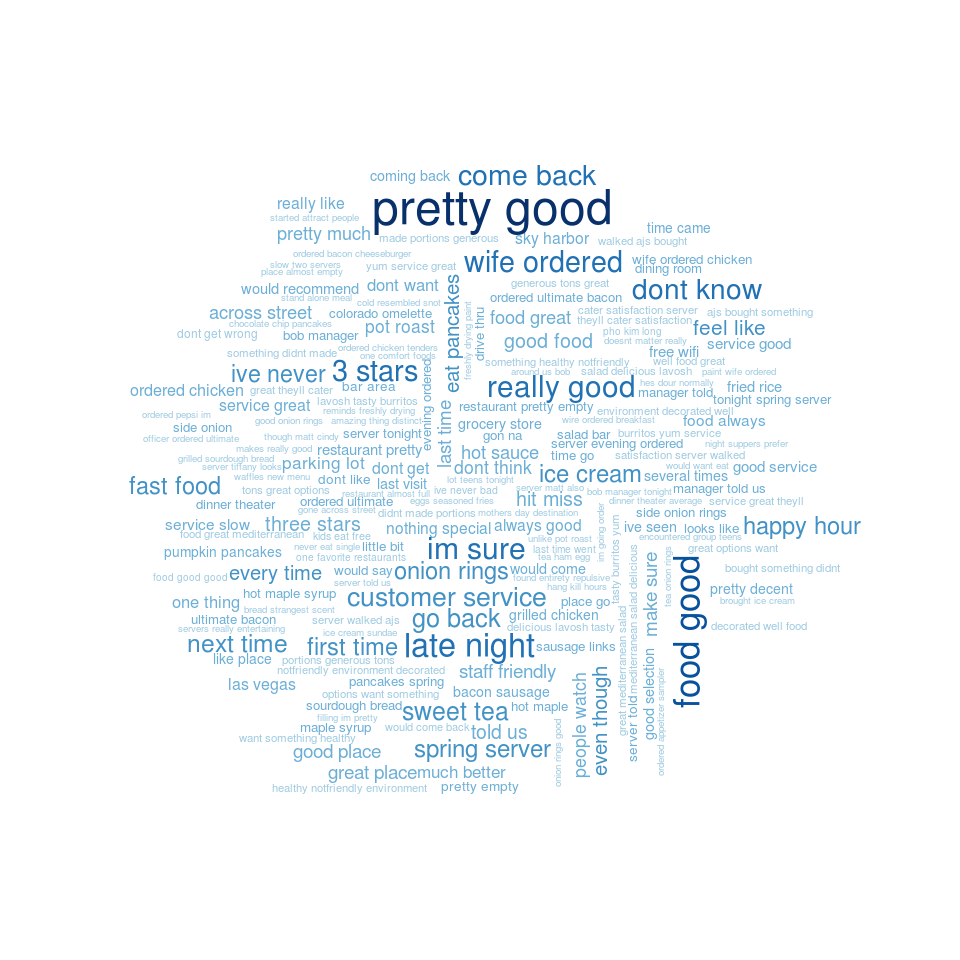

In [20]:
from IPython.core.display import Image
Image(filename=os.path.join(yelp_output_dir, '3_star_wordcloud.png'))

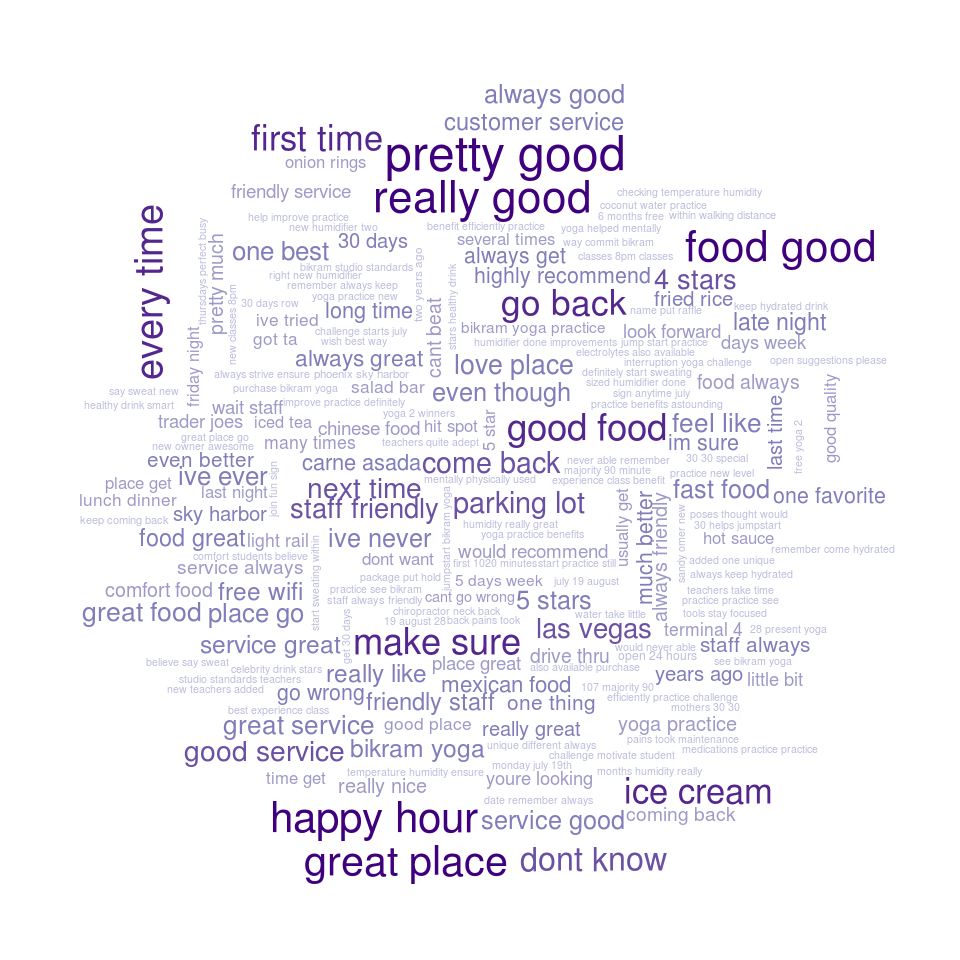

In [21]:
from IPython.core.display import Image
Image(filename=os.path.join(yelp_output_dir, '4_star_wordcloud.png'))

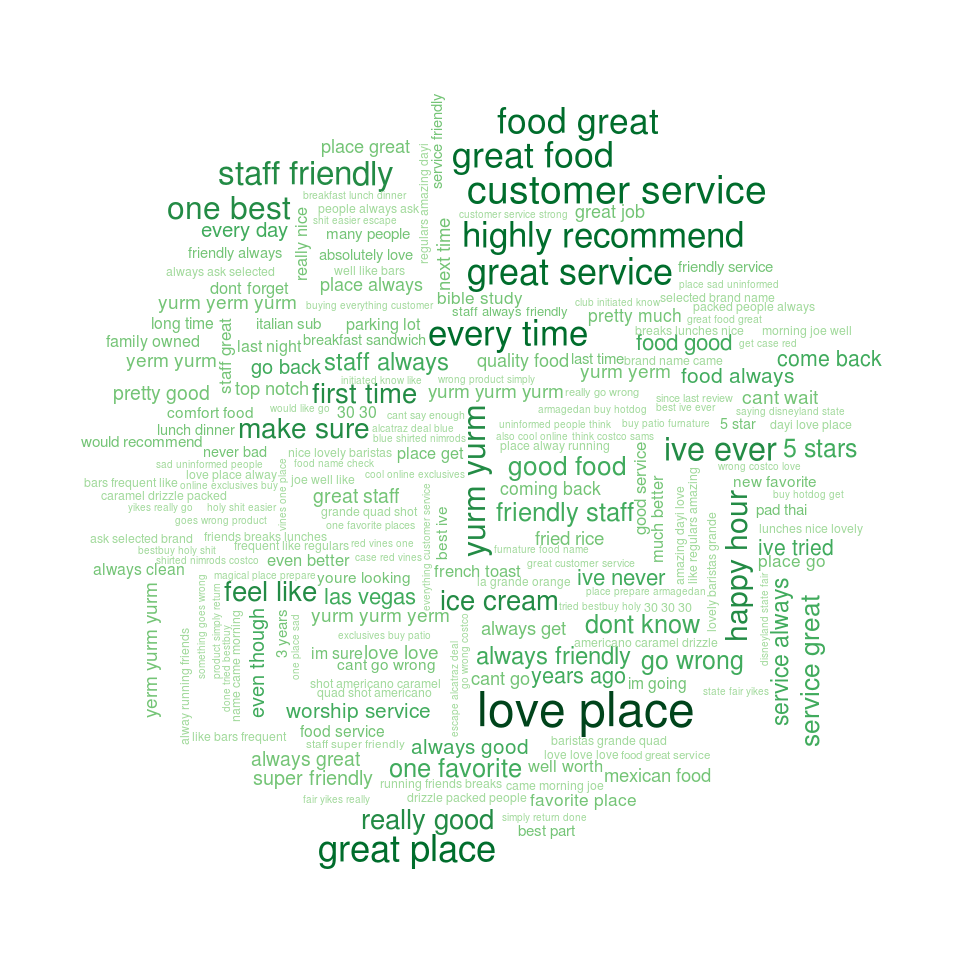

In [22]:
from IPython.core.display import Image
Image(filename=os.path.join(yelp_output_dir, '5_star_wordcloud.png'))

## Feature Engineering

In [10]:
stemmer = PorterStemmer()
    
def remove_numbers_in_string(s):
    return s.translate(None, string.digits) # preprocess_and_tokenize does not remove digits for wordcloud visualization's sake

def stem_token_list(token_list):
    return [stemmer.stem(tok.decode('utf-8')) for tok in token_list]

def restring(token_list):
    return ' '.join(token_list)

def lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring(s):
    s = remove_numbers_in_string(s)
    token_list = lowercase_remove_punctuation_and_tokenize(s)
    token_list = stem_token_list(token_list)
    return restring(token_list)

In [11]:
initial_features = ['business_id', 'business_name', 'review_stars', 'review_text']
df_with_initial_features = all_DF[initial_features]
df_with_initial_features['review_text'] = df_with_initial_features['review_text'].apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)
df_with_initial_features['review_stars'] = df_with_initial_features['review_stars'].apply(lambda star_num : [star_num])

def get_series_describing_apply_on_each_column(df):
    return Series({'business_name': df.business_name.unique()[0], 'review_stars': df.review_stars.sum(), 'review_text': ' '.join(df.review_text)})

df_with_initial_features_indexed_by_business = df_with_initial_features.groupby('business_id').apply(get_series_describing_apply_on_each_column)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
df_with_initial_features_and_preprocessed_review_text = all_DF[initial_features]
df_with_initial_features_and_preprocessed_review_text['review_text'] = df_with_initial_features_and_preprocessed_review_text['review_text'].apply(lowercase_remove_punctuation_and_numbers_and_tokenize_and_filter_more_stopwords_and_stem_and_restring)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [14]:
vectorizer = CountVectorizer(min_df=1) 
corpus_as_series_of_review_texts_groupedby_business_id = df_with_initial_features_indexed_by_business['review_text']
corpus_as_string_array = corpus_as_series_of_review_texts_groupedby_business_id.values
document_term_matrix = vectorizer.fit_transform(corpus_as_string_array)

In [15]:
vectorizer_2 = CountVectorizer(min_df=3) 
dt_matrix = vectorizer_2.fit_transform(df_with_initial_features_and_preprocessed_review_text.review_text.values)

In [16]:
np.savetxt('features.txt', np.array(map(lambda s : s.encode('utf-8'), vectorizer_2.get_feature_names())), fmt='%s')
np.savetxt('stars.txt', df_with_initial_features_and_preprocessed_review_text.review_stars.values)
np.savez('dt_matrix', data = dt_matrix.data ,indices=dt_matrix.indices,indptr =dt_matrix.indptr, shape=dt_matrix.shape)

In [30]:
!wc -l features.txt

14372 features.txt


In [18]:
feature_words = vectorizer.get_feature_names()
feature_words_frequencies = document_term_matrix.sum(axis=0).tolist()[0]
word_frequency_map = dict(zip(feature_words, feature_words_frequencies))

feature_words_file_path = os.path.join(yelp_output_dir, 'feature_words_with_6002_samples_of_tf.txt')
word_freq_df = DataFrame.from_dict(Counter(word_frequency_map).most_common(len(feature_words)))
word_freq_df.to_csv(feature_words_file_path, index=False, header=['word', 'freq'], encoding='utf-8')

!head $feature_words_filepath

word,freq
place,18961
good,17209
food,16801
get,15523
great,15183
like,13877
go,13869
time,13776
one,12129


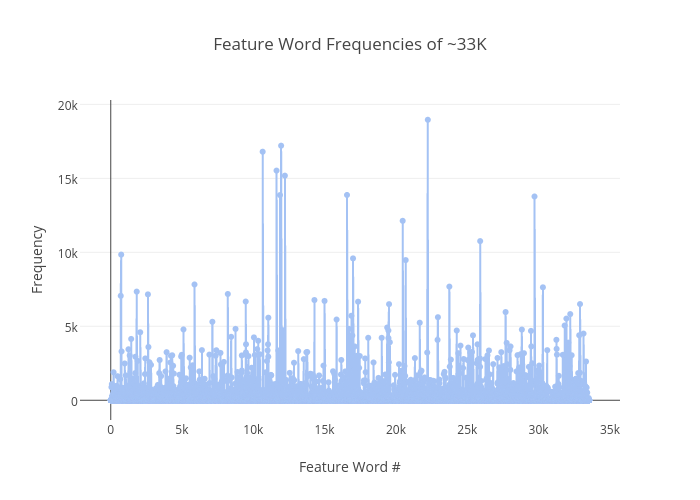

In [1]:
yelpdata = Data([Scatter(x=list(range(len(feature_words))),
                     y=feature_words_frequencies,
                     mode='lines+markers',
                     text=feature_words,
                     marker=Marker(color='rgb(164,194,244)'),
                     line=Line(shape='linear'))])

layout = Layout(title='Feature Word Frequencies of ~33K',
                xaxis=XAxis(title='Feature Word #', showgrid=False),
                yaxis=YAxis(title='Frequency', showline=False))

fig = Figure(data=yelpdata, layout=layout)
py.iplot(fig, filename='Feature Word Frequencies of ~33K') 

In [ ]:
mean_document = document_term_matrix.mean(axis=0)
centered_document_term_matrix = document_term_matrix.toarray() - mean_document
n = len(centered_document_term_matrix)
print "we have n = %d sample documents and d = %d feature words " % (n, len(vectorizer.get_feature_names()))
centered_document_term_matrix *= (1.0/n)
z_document_term_matrix = centered_document_term_matrix

we have n = 6002 sample documents and d = 33540 feature words 


In [ ]:
svd = TruncatedSVD(n_components = 100)
model = svd.fit(z_document_term_matrix)
X_proj = model.transform(z_document_term_matrix)

In [ ]:
total_variance = np.var(z_document_term_matrix, axis=0).sum()
variances_of_empirical_data_training_samples_projected_onto_pcs = np.var(X_proj, axis=0)
true_explained_variance_ratio = variances_of_empirical_data_training_samples_projected_onto_pcs / total_variance

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning:

findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning:

findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=x-large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf



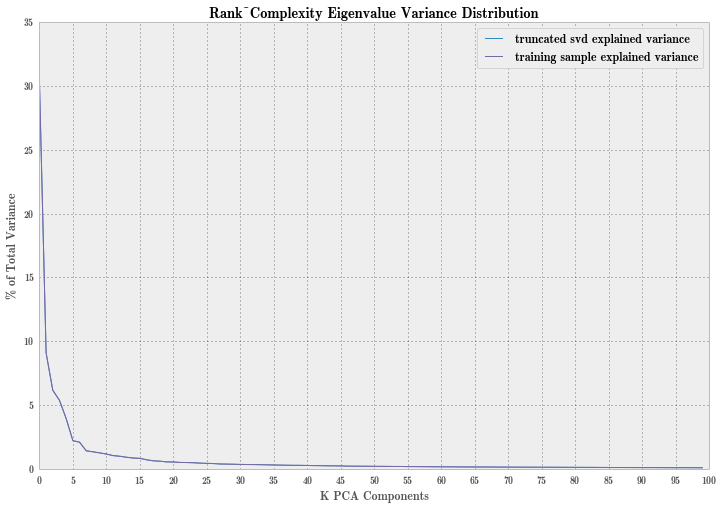

In [24]:
plt.figure(figsize=(12,8))
plt.plot(100*model.explained_variance_ratio_, label='truncated svd explained variance')
plt.plot(100*true_explained_variance_ratio, label='training sample explained variance')
plt.xticks(np.arange(0, 105, 5))
plt.legend(loc='best')
plt.xlabel('K PCA Components')
plt.ylabel('% of Total Variance')
plt.title('Rank~Complexity Eigenvalue Variance Distribution')

In [27]:
print "%d components explain %f of the variance in our term document matrix" % (100, sum(model.explained_variance_ratio_))
print "top 2 PC's explain %f of the variance" % (sum(model.explained_variance_ratio_[0:2]))

100 components explain 0.876594 of the variance in our term document matrix
top 2 PC's explain 0.395874 of the variance


## Highest component loadings

In [ ]:
PC1 = svd.components_[0]
PC2 = svd.components_[1]

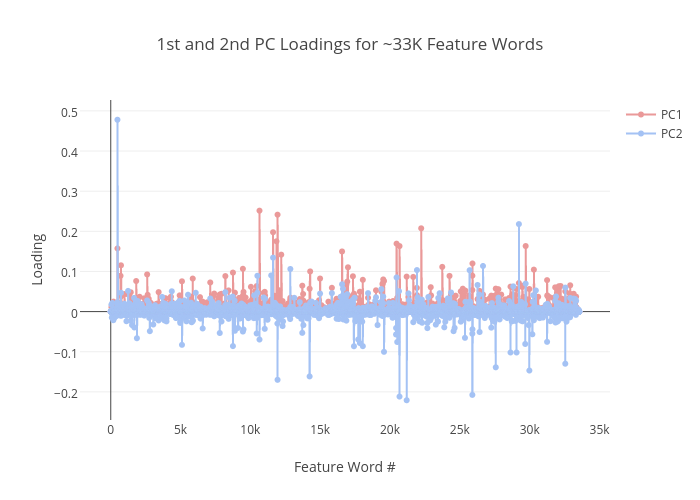

In [1]:
trace1 = Scatter(x=list(range(len(PC1))), y=PC1, mode='lines+markers', name='PC1', text=feature_words,
                 marker=Marker(color='rgb(234, 153, 153)'), line=Line(shape='linear'))
trace2 = Scatter(x=list(range(len(PC2))), y=PC2, mode='lines+markers', name='PC2', text=feature_words,
                 marker=Marker(color='rgb(164, 194, 244)'), line=Line(shape='linear'))
data = Data([trace1, trace2])
layout = Layout(title='1st and 2nd PC Loadings for ~33K Feature Words',
                xaxis=XAxis(title='Feature Word #', showgrid=False),
                yaxis=YAxis(title='Loading', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='lsa_pca_loadings_yelp_duygu')

In [34]:
def average_and_round(review_stars_list):
    return np.rint(np.mean(review_stars_list))

PC1_proj = X_proj[:,0]
PC2_proj = X_proj[:,1]
df_with_initial_features_indexed_by_business['rounded_average_stars'] = df_with_initial_features_indexed_by_business.review_stars.apply(average_and_round)#
df_with_initial_features_indexed_by_business['PC1'] = PC1_proj
df_with_initial_features_indexed_by_business['PC2'] = PC2_proj

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



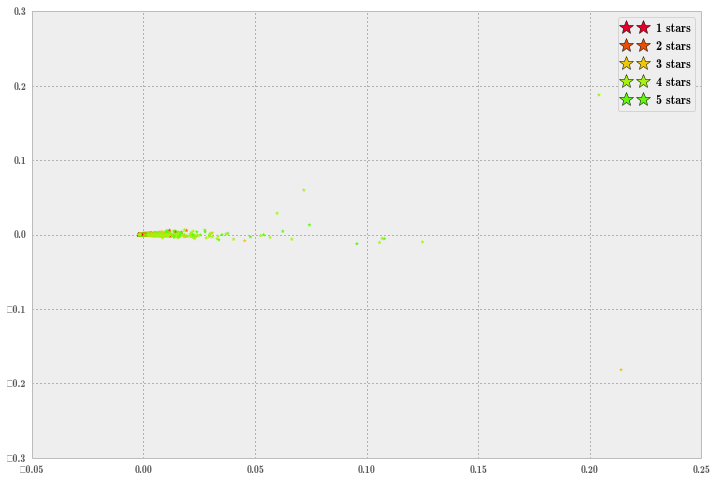

In [40]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

plt.figure(figsize=(12,8))
plt.scatter(df_with_initial_features_indexed_by_business.PC1, 
            df_with_initial_features_indexed_by_business.PC2, marker='*',
            c=colors[df_with_initial_features_indexed_by_business.rounded_average_stars-1], edgecolors='none')


star_markers = [mlines.Line2D([],[],color=c, marker='*',markersize=15, lw=0) for c in colors]
plt.legend(star_markers, map(lambda x : '{0} stars'.format(x), range(1,6)), loc='best')

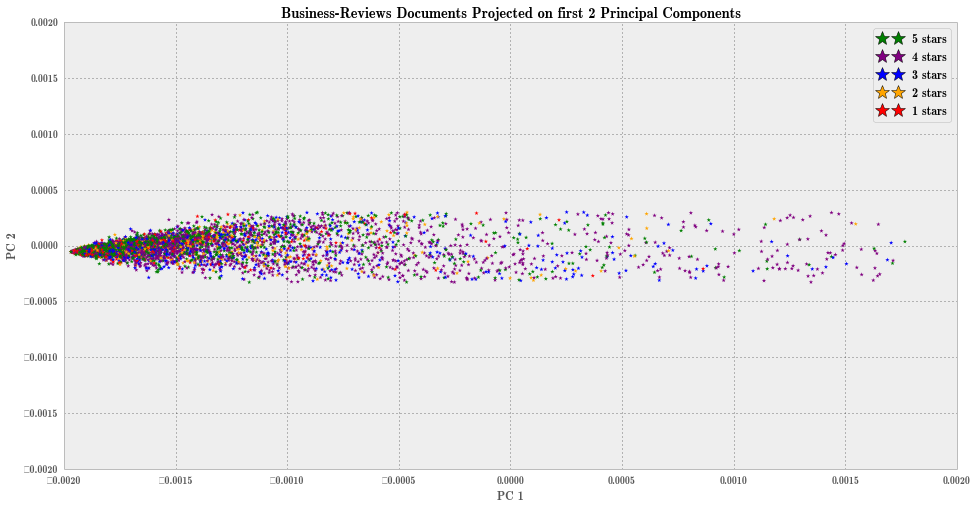

In [41]:
PC1_5SS = df_with_initial_features_indexed_by_business.PC1.describe()
PC1 = df_with_initial_features_indexed_by_business.PC1
PC2 = df_with_initial_features_indexed_by_business.PC2

PC1_IQR = PC1_5SS['75%'] - PC1_5SS['25%']
indices_for_PC1_outliers = (PC1 < PC1_5SS['25%'] - 1.5*PC1_IQR) | (PC1 > PC1_5SS['75%'] + 1.5*PC1_IQR)

PC1_5SS = df_with_initial_features_indexed_by_business.PC1.describe()
PC1_IQR = PC1_5SS['75%'] - PC1_5SS['25%']
indices_for_PC1_outliers = (PC1 < PC1_5SS['25%'] - 1.5*PC1_IQR) | (PC1 > PC1_5SS['75%'] + 1.5*PC1_IQR)

PC2_5SS = df_with_initial_features_indexed_by_business.PC2.describe()
PC2_IQR = PC2_5SS['75%'] - PC2_5SS['25%']
indices_for_PC2_outliers = (PC2 < PC2_5SS['25%'] - 1.5*PC2_IQR) | (PC2 > PC2_5SS['75%'] + 1.5*PC2_IQR)

PC2_5SS = df_with_initial_features_indexed_by_business.PC2.describe()
PC2_IQR = PC2_5SS['75%'] - PC2_5SS['25%']
indices_for_PC2_outliers = (PC2 < PC2_5SS['25%'] - 1.5*PC2_IQR) | (PC2 > PC2_5SS['75%'] + 1.5*PC2_IQR)

sub = df_with_initial_features_indexed_by_business[~(indices_for_PC1_outliers | indices_for_PC2_outliers)]

plt.figure(figsize=(16,8))
colors = np.array(['red', 'orange', 'blue', 'purple', 'green']) # 1, 2, 3, 4, and 5 stars respectively
plt.scatter(sub.PC1, 
            sub.PC2, marker='*',
            c=colors[sub.rounded_average_stars-1], edgecolors='none')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Business-Reviews Documents Projected on first 2 Principal Components')

star_markers = [mlines.Line2D([],[],color=c, marker='*',markersize=15, lw=0) for c in colors]
plt.legend(reversed(star_markers), reversed(map(lambda x : '{0} stars'.format(x), range(1,6))), loc='best')

plt.gca().set_xlim([-0.002, 0.002])
plt.gca().set_ylim([-0.002, 0.002])
None

In [ ]:
figure_name = 'Business-Reviews Documents Projected onto first 2 Principal Components'

def make_scatter_trace(x_stars):
    return Scatter(x=sub.PC1[sub.rounded_average_stars==x_stars],
                   y=sub.PC2[sub.rounded_average_stars==x_stars],
                   mode='markers',name='{0} stars'.format(x_stars),
                   marker=Marker(color=colors[x_stars-1]),
                   text=sub.business_name[sub.rounded_average_stars==x_stars])

data = Data([make_scatter_trace(x+1) for x in range(5)])
layout = Layout(title=figure_name,
                xaxis=XAxis(title='Projection onto PC 1'),
                yaxis=YAxis(title='Projection onto PC 2'))

fig = Figure(data=data, layout=layout)

py.iplot(fig, filename=figure_name)

## Business-review correlation

In [1]:
#TOP_NUM_COMPONENT_LOADINGS = 1000

PC1 = svd.components_[0]
PC2 = svd.components_[1]

PC1_with_feature_word = [(feature_words[i], component_loading) for (i, component_loading) in enumerate(PC1)]
PC2_with_feature_word = [(feature_words[i], component_loading) for (i, component_loading) in enumerate(PC2)]

def get_component_loading(feature_word_and_component_loading_pair):
    return feature_word_and_component_loading_pair[1]

def get_feature_word(feature_word_and_component_loading_pair):
    return feature_word_and_component_loading_pair[0]

# we wish to find the maximum component loadings of PC1 and PC2
top_PC1_feature_words_and_component_loadings = sorted(PC1_with_feature_word, key=get_component_loading,reverse=True)[0:TOP_NUM_COMPONENT_LOADINGS]
top_PC2_feature_words_and_component_loadings = sorted(PC2_with_feature_word, key=get_component_loading,reverse=True)[0:TOP_NUM_COMPONENT_LOADINGS]

top_PC1_feature_words = map(get_feature_word, top_PC1_feature_words_and_component_loadings)
top_PC2_feature_words = map(get_feature_word, top_PC2_feature_words_and_component_loadings)


In [5]:
pc1_component_loadings_file_path = os.path.join(yelp_output_dir, 'pc1_top_{0}_component_loadings.txt'.format(TOP_NUM_COMPONENT_LOADINGS))
pc2_component_loadings_file_path = os.path.join(yelp_output_dir, 'pc2_top_{0}_component_loadings.txt'.format(TOP_NUM_COMPONENT_LOADINGS))
    
f = open(pc1_component_loadings_file_path, 'w')

for w in top_PC1_feature_words:
    f.write(w.encode('utf-8') + '\n')

f.close()

f = open(pc2_component_loadings_file_path, 'w')

for w in top_PC2_feature_words:
    f.write(w.encode('utf-8') + '\n')
    
f.close()
    
!head $PC1_COMPONENT_LOADINGS_FILEPATH
!echo
!head $PC2_COMPONENT_LOADINGS_FILEPATH

food
good
place
get
go
one
time
order
airport
like

airport
termin
get
sky
harbor
phoenix
secur
gate
flight
one


In [47]:
from scipy import sparse
reduced_document_term_matrix = None

In [48]:
top_PC1_feature_words_indices = map(feature_words.index, top_PC1_feature_words)
top_PC2_feature_words_indices = map(feature_words.index, top_PC2_feature_words)
ascending_ordered_indices = sorted(top_PC1_feature_words_indices + top_PC2_feature_words_indices)

reduced_document_term_matrix = document_term_matrix[:, ascending_ordered_indices]
reduced_document_term_matrix.shape

(6002, 2000)

In [57]:
reduced_doc_term_matrix_filepath = os.path.join(yelp_output_dir, 'reduced_document_term_matrix.csv')

if not os.path.exists(reduced_doc_term_matrix_filepath):
    reduced_document_term_matrix_df = DataFrame(data=reduced_document_term_matrix.toarray())
    reduced_document_term_matrix_df.columns = [feature_words[i] for i in ascending_ordered_indices]
    reduced_document_term_matrix_df.to_csv(reduced_doc_term_matrix_filepath, index=False, encoding='utf-8')
elif reduced_document_term_matrix is None:
    reduced_document_term_matrix_df = DataFrame.from_csv(reduced_doc_term_matrix_filepath, index_col=False)
    reduced_document_term_matrix = sparse.csr_matrix(reduced_document_term_matrix_df.as_matrix())

In [50]:
def sparse_corrcoef_sample_similarity(X): # assume X is an n by d matrix, where n = # of samples and d = # of features
    X = X.todense()
    X_conj = X.conj()
    
    n_samples, d_features = X.shape
    norm = np.float64(n_samples-1)
    Cov = (X * X.T) / norm
    
    variances = np.diag(Cov)
    Coeff = Cov / np.sqrt(np.outer(variances, variances))
    return Coeff

business_reviews_document_corr = sparse_corrcoef_sample_similarity(reduced_document_term_matrix)
business_reviews_document_corr.shape

(6002, 6002)

In [59]:
where_NaNs_are = np.isnan(business_reviews_document_corr)
business_reviews_document_corr[where_NaNs_are] = 0
range_business_reviews_corr = (business_reviews_document_corr.min(), business_reviews_document_corr.max())
range_business_reviews_corr

(0.0, 1.0)

In [52]:
business_reviews_corr_matrix_filepath = os.path.join(yelp_output_dir, 'business_reviews_correlation_matrix.csv')

if not os.path.exists(business_reviews_corr_matrix_filepath):
    business_reviews_correlation_matrix_df = DataFrame(data=business_reviews_document_corr)
    business_reviews_correlation_matrix_df.columns = df_with_initial_features_indexed_by_business.business_name
    business_reviews_correlation_matrix_df.to_csv(business_reviews_corr_matrix_filepath, encoding='utf-8', index=False)
else:
    business_reviews_correlation_matrix_df = DataFrame.from_csv(business_reviews_corr_matrix_filepath, index_col=False)

In [53]:
checkin_json_filename = os.path.join(clean_data_dir, 'yelp_academic_dataset_checkin.json')
checkin_df = pd.read_json(checkin_json_filename)
TOP_N_BUSINESSES_CHECKEDIN = 100
checkin_df['number_of_checkins'] = checkin_df.checkin_info.apply(len)

In [54]:
df_with_initial_features_indexed_by_business['business_id'] = df_with_initial_features_indexed_by_business.index.values
df_with_initial_features_and_checkins_indexed_by_business = DataFrame.merge(df_with_initial_features_indexed_by_business,
                                                                            checkin_df, on='business_id')

ncheckins_column = df_with_initial_features_and_checkins_indexed_by_business.number_of_checkins.values
index_and_ncheckins = Counter(dict([(i, ncheckins) for (i, ncheckins) in enumerate(ncheckins_column)]))
def get_index(index_ncheckin_pair): return index_ncheckin_pair[0]

indices_ordered_by_descending_number_of_checkins = map(get_index, index_and_ncheckins.most_common(TOP_N_BUSINESSES_CHECKEDIN))
# select the TOP N BUSINESSES CHECKEDIN ROWS and COLS
business_reviews_correlation_to_visualize_matrix_df = business_reviews_correlation_matrix_df.loc[indices_ordered_by_descending_number_of_checkins][indices_ordered_by_descending_number_of_checkins]
# for x and y labels
corresponding_business_names = business_reviews_correlation_to_visualize_matrix_df.columns.values
# to matrix form so for heatmap visualization
business_reviews_correlation_to_visualize_matrix = business_reviews_correlation_to_visualize_matrix_df.as_matrix()

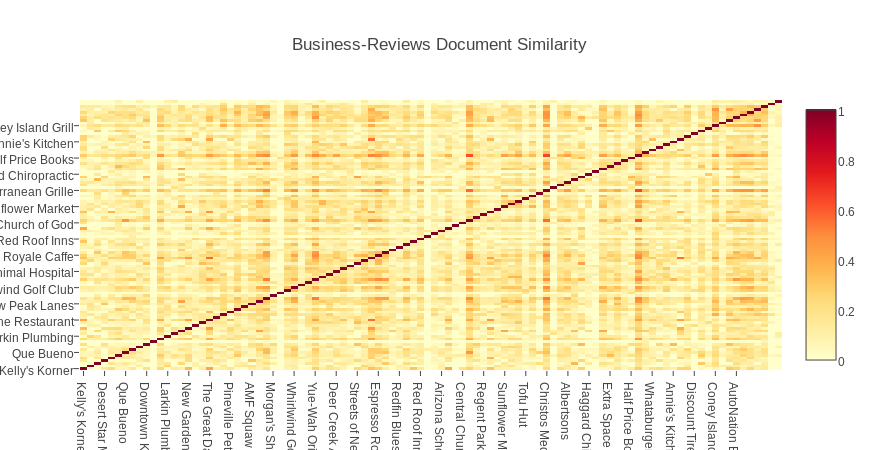

In [2]:
'''
title = 'Business-Reviews Document Similarity'

hmap = Heatmap(z=business_reviews_correlation_to_visualize_matrix,
               x=corresponding_business_names,
               y=corresponding_business_names,
               colorscale='YIOrRd',
               reversescale=True)

data = Data([hmap])
layout = Layout(title=title, margin=Margin(autoexpand=True))

fig = Figure(data=data, layout=layout)
url = py.plot(fig, filename='business_reviews_document_similarity_heatmap', auto_open=False)
print url
py.iplot(fig, filename='business_reviews_document_similarity_heatmap')
'''
from IPython.display import Image
Image(filename='heat.png') 

## Feature Word Similarity

In [56]:
term_document_matrix = reduced_document_term_matrix.T

In [58]:
mean_word = term_document_matrix.mean(axis=0)
centered_term_document_matrix = term_document_matrix.toarray() - mean_word
n = len(centered_term_document_matrix)
z_centered_term_document_matrix = (1.0/n)*centered_term_document_matrix
z_centered_term_document_matrix.shape

(2000, 6002)

In [60]:
svd = TruncatedSVD(n_components = 100)
word_similarity_model = svd.fit(z_centered_term_document_matrix) 
X_proj = word_similarity_model.transform(z_centered_term_document_matrix)

In [61]:
word_similarity_proj_df = DataFrame({'words' : np.array(reduced_document_term_matrix_df.columns), 'PC1' : X_proj[:,1], 'PC2' : X_proj[:,2]})
word_similarity_proj_df.set_index(word_similarity_proj_df.words, inplace=True)

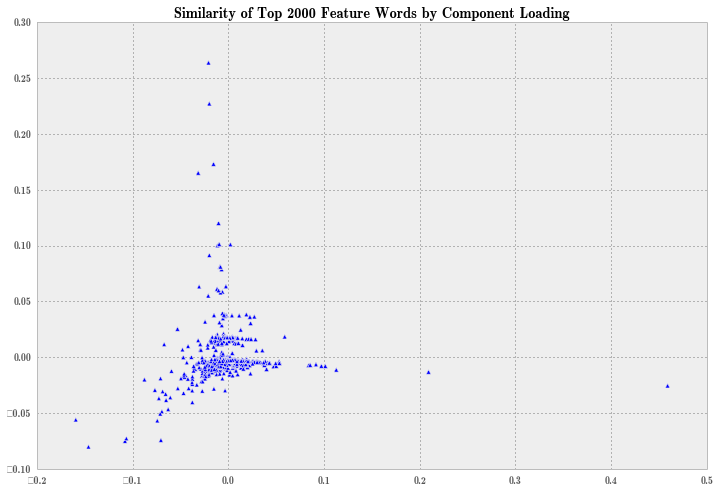

In [62]:
plt.figure(figsize=(12,8))
plt.scatter(word_similarity_proj_df.PC1, 
            word_similarity_proj_df.PC2, marker='^')
plt.title('Similarity of Top 2000 Feature Words by Component Loading')

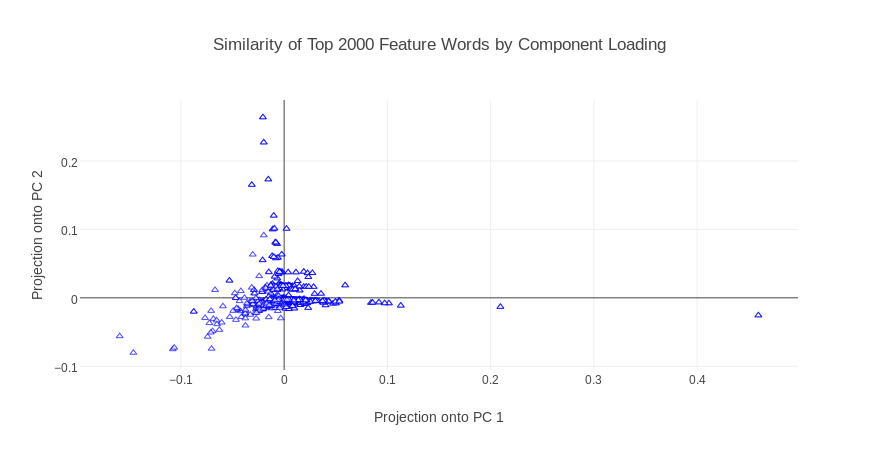

In [5]:
'''
trace = Scatter(x=word_similarity_proj_df.PC1,
                y=word_similarity_proj_df.PC2,
                mode='markers', marker=Marker(symbol='triangle-up',
                                              color='white',
                                              line=Line(color='blue',width=1.0),
                                              opacity=0.7),
                text=word_similarity_proj_df.words)

data = Data([trace])
layout = Layout(title='Similarity of Top 2000 Feature Words by Component Loading',
                xaxis=XAxis(title='Projection onto PC 1'),
                yaxis=YAxis(title='Projection onto PC 2'))

fig = Figure(data=data, layout=layout)

url = py.plot(fig, filename='similarity_top_2000_feature_words_by_component_loading', auto_open=False)
print url
py.iplot(fig, filename='similarity_top_2000_feature_words_by_component_loading')
'''
from IPython.display import Image
Image(filename='similar.png') 

## Summary